In [1]:
# Project: Financial Anomaly Detection and Risk Analysis
# Name: Jemma Tang
# Date: 09/24/2020
# Dataset resource: https://www.kaggle.com/mlg-ulb/creditcardfraud

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns, numpy as np

from numpy import genfromtxt
from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score
import io
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

In [5]:
creditcardDF = pd.read_csv("creditcard.csv")
creditcardDF.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [15]:
# Part1: understanding my data and get basic senses

In [ ]:
# Except for 1st column 'Time' and 30th column 'Amount', I don't know anything else because the privacy reasons.
# V1 to V28 are encrypted data 
# Although we don't know what the "V" features stand for, it will be useful to understand how each of this features influence the result (Fraud or No Fraud) 
# 'Class' is my label data. 0 = normal transaction, 1 = anomaly transaction.

In [7]:
creditcardDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [ ]:
# There are no null values so I don't need to deal with missing values.

In [8]:
creditcardDF['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [14]:
sum( creditcardDF['Class'] == 1 )/ creditcardDF['Class'].count()

0.001727485630620034

In [ ]:
# Fraud rate is very low 0.17%, original dataset is very imbalanced
# If we use this dataframe as the base for our predictive models and analysis we might get a lot of errors 
# and our algorithms will probably overfit since it will "assume" that most transactions are not fraud.


In [16]:
creditcardDF.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


<AxesSubplot:xlabel='Time'>

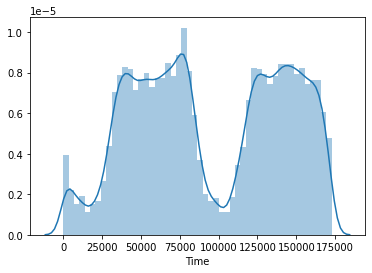

In [17]:
# distribution of transaction time
sns.distplot(creditcardDF['Time'])

<AxesSubplot:xlabel='Amount'>

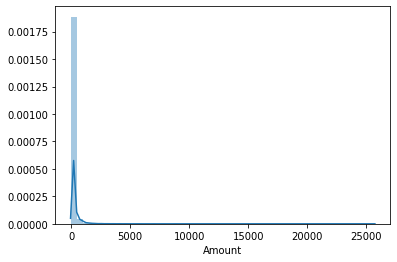

In [19]:
# distribution of transaction amount
sns.distplot(creditcardDF['Amount'])

(array([284315.,    492.]),
 array([0, 1, 2]),
 <BarContainer object of 2 artists>)

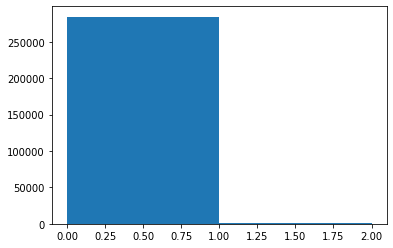

In [27]:
# distribution of fraud data
plt.hist(creditcardDF['Class'], bins = range(0, 3, 1))

In [ ]:
# By seeing the distributions we can have an idea how skewed are these features

In [ ]:
# Part2: preprocessing data
# 1. using log to scale Amount and Time data
# 2. split trani and test data

In [31]:
# log transforms all amount and time features
creditcardDF['Amount'] = np.log(creditcardDF['Amount'] + 1)
creditcardDF['Time'] = np.log(creditcardDF['Time'] + 1)

In [36]:
# began to split fraud and non-fraud data
normal = creditcardDF[creditcardDF['Class'] == 0]
anomaly = creditcardDF[creditcardDF['Class'] == 1]

In [40]:
# 80% of normals are trainning data, 20% of normals are testing data
train, test = train_test_split(normal, test_size=0.2, random_state=0)

# Among all testing data, 50% are used for normal validation, 50% normal tesing data
normal_valid, normal_test = train_test_split(test, test_size=0.5, random_state=0)

# Among all fraud data (492 cases), 50% of fraud used for validation, 50% fraud for testing data
anomaly_valid, anomaly_test = train_test_split(anomaly, test_size=0.5, random_state=0)#all anomaly/bad

In [ ]:
# Overall: all traning data are non-fraud, validating/testing data has 50% fraud each.

In [41]:
validation = pd.concat([normal_valid, anomaly_valid])#include both good and bad
test = pd.concat([normal_test, anomaly_test])#include both good and bad

In [42]:
print(validation.shape)
print(test.shape)

train = train.drop(columns = ['Class']).reset_index(drop= True)#no need of label in train data, drop it
print(train.shape)

(28677, 31)
(28678, 31)
(227452, 30)


In [48]:
featureNames = list(train.columns.values)#feature names only, no label
valFeatures = validation[featureNames].reset_index(drop= True)#feature df only, no label
testFeatures = test[featureNames].reset_index(drop= True)#feature df only, no label

valLabel = validation['Class']#label df only
testLabel = test['Class']#label df only

In [49]:
# validation data having only features columns
valFeatures.head() 

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,11.827043,-0.248023,1.259502,-0.993999,-1.587788,1.913462,-0.630270,1.958852,-0.659274,0.002373,...,0.396605,0.089915,0.896611,-0.367547,0.143515,-0.177558,0.025269,0.271419,-0.066416,0.406979
1,10.809566,-1.614505,-0.970137,1.730517,-1.715497,-0.869271,-0.171355,1.216768,-0.031314,0.992762,...,0.831753,0.408654,0.630537,0.382848,-0.110627,0.906539,-0.618206,-0.026364,0.104561,0.729614
2,11.340380,1.106176,0.148096,0.424489,1.282916,-0.080275,0.146526,-0.007108,0.114953,-0.004731,...,-0.148073,-0.042488,0.071593,-0.085294,0.032780,0.637894,-0.331179,0.036130,0.007639,0.618090
3,11.321208,-1.791995,1.102738,0.324217,1.082267,-0.303348,-1.050303,0.066270,0.613586,-0.720545,...,-0.285331,0.151935,0.514245,0.290932,0.403345,-0.064118,-0.318054,0.021940,0.013401,0.648074
4,11.956784,1.924286,0.324362,-0.734639,3.370481,0.783552,1.224944,-0.298881,0.291717,-0.790152,...,-0.227395,-0.022543,-0.115448,0.143200,-0.357497,-0.109288,-0.105516,-0.025440,-0.050761,0.599513


In [51]:
# testing data having only features columns
testFeatures.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,10.754002,1.197337,-0.094470,-0.370282,-0.159653,0.081626,-0.467761,0.261166,-0.174461,-0.289589,...,0.125207,-0.039809,-0.250918,-0.209802,-0.409802,0.500821,1.034294,-0.115533,-0.009900,0.683352
1,11.885330,-0.191617,0.937803,0.169863,-0.623206,0.262791,-1.187661,0.907601,-0.126031,0.333635,...,0.003997,-0.306218,-0.690425,0.111420,0.001373,-0.476772,0.147261,0.347417,0.153287,0.336847
2,11.704463,1.863703,0.338429,0.339123,3.882610,-0.280891,0.244318,-0.459143,0.052683,-0.402713,...,-0.221016,0.184672,0.697386,0.177146,0.049079,-0.205933,0.022688,0.022768,-0.028652,0.550407
3,11.151439,-0.893100,1.314857,1.169805,1.397126,-0.368209,-0.202039,0.185825,0.527681,-0.281365,...,-0.078757,0.029692,0.249239,-0.034148,0.399384,-0.148717,-0.250188,0.169235,0.137246,0.534210
4,9.271530,-0.732857,0.675073,1.698804,-1.217482,0.121983,-0.547678,0.417747,0.046242,1.047147,...,0.080186,-0.182529,-0.338531,-0.042062,-0.035442,-0.341831,0.683327,0.215166,0.157955,0.639539


In [53]:
validation['Class'].value_counts()

0    28431
1      246
Name: Class, dtype: int64

In [52]:
test['Class'].value_counts()

0    28432
1      246
Name: Class, dtype: int64

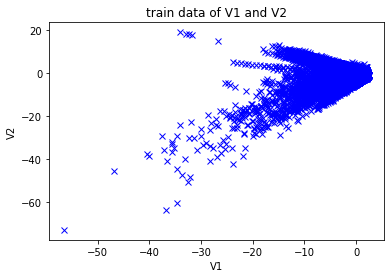

In [54]:
plt.figure()
plt.title("train data of V1 and V2")#may contain outliers
plt.xlabel("V1")
plt.ylabel("V2")
plt.plot(train.iloc[:, 1],train.iloc[:,2],"bx") # all rows, v1; all rows, v2
plt.show()

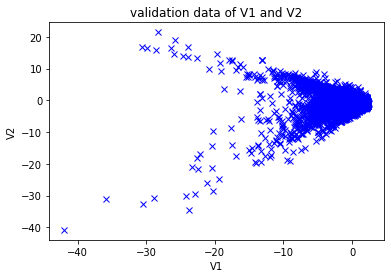

In [55]:
plt.figure()
plt.title("validation data of V1 and V2")
plt.xlabel("V1")
plt.ylabel("V2")
plt.plot(validation.iloc[:, 1],validation.iloc[:,2],"bx")
plt.show()

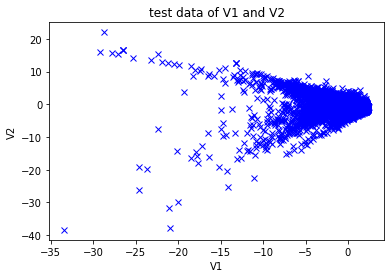

In [56]:
plt.figure()
plt.title("test data of V1 and V2")
plt.xlabel("V1")
plt.ylabel("V2")
plt.plot(test.iloc[:, 1],test.iloc[:,2],"bx")
plt.show()

In [ ]:
# What I am going to do is based on the training data, estimate mean and variance and build a p(x) function,
# For validation set, I use different episilons as threshold values

In [57]:
#find parameter for each col/feature in df for the Gaussian distribution
def estimateGaussian(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.cov(dataset.T)
    return mu, sigma

In [58]:
#step 1: model training
mu, sigma = estimateGaussian(train)

#generate The probability density function/curve/surface/model for multivariate_normal given mean and cov 
model = multivariate_normal(mean=mu, cov=sigma, allow_singular = True)#surface hat

In [59]:
pdfVal = model.pdf(valFeatures)
print(max(pdfVal))#too small, can not differentiate
print(min(pdfVal))

p_val = model.logpdf(valFeatures)#Log of the pdf first, then apply to features, to change the magnitude of prob
print(max(p_val))#
print(min(p_val))

4.806105409916265e-11
0.0
-23.758548952877756
-7557.9486504418865


In [60]:
p = model.logpdf(train)
print(p.shape)
print((p_val.shape))

print(p)

(227452,)
(28677,)
[-28.57944914 -41.34982857 -30.59432922 ... -28.32018916 -33.36981832
 -35.87051495]


In [61]:
print(p_val)
print(p_val < -500)

[  -28.87505368   -32.07872261   -25.43112649 ... -5173.15880367
 -4542.34000189   -27.55397213]
[False False False ...  True  True False]


In [64]:
scores = []
p_val = model.logpdf(valFeatures)#Log of the pdf

# thresholds = np.linspace(-1000, -10,150)
thresholds = np.linspace(min(p_val), max(p_val),200)#generate all candidate threshold, epsilon

#step 2: CV to find optimal threshold: bestThreshold
for threshold in thresholds:
    y_pred = (p_val < threshold).astype(int)# list of 0 and 1
  #calculate recall, precision and f1 for each (truth, pred) pair, corresponding to that threshold
    scores.append([recall_score(valLabel, y_pred),
                 precision_score(valLabel, y_pred),
                 f1_score(valLabel, y_pred, average = "binary")])

scores = np.array(scores)
maxIndex = scores[...,2].ravel().argmax()#maxIndex of the column 2(f1_score) #193
bestThreshold = thresholds[maxIndex]
print(scores.shape)#each row is a pair of (recall, precision, f1) corresponding to a threshold

(200, 3)


In [65]:
print(scores)

[[0.         0.         0.        ]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00406504 1.         0.00809717]
 [0.00813008 1.         0.01612903]
 [0.00813008 1.         0.01612903]
 [0.00813008 1.         0.01612903]
 [0.00813008 1.         0.01612903]
 [0.00813008 1.         0.01

In [66]:
print(maxIndex)
print(bestThreshold)

193
-250.92005955053628


In [67]:
np.mean(train.iloc[:,1])

0.00524675542006222

In [68]:
mu[1]

0.005246755420062154

In [69]:
print(mu)
# print(sigma)

Time      11.252384
V1         0.005247
V2        -0.005416
V3         0.010293
V4        -0.008144
V5         0.004281
V6         0.001813
V7         0.010354
V8        -0.001103
V9         0.006351
V10        0.009573
V11       -0.007736
V12        0.009943
V13        0.001084
V14        0.010816
V15        0.001082
V16        0.007216
V17        0.012364
V18        0.003412
V19       -0.001811
V20       -0.001092
V21       -0.001302
V22       -0.000354
V23        0.000209
V24        0.000288
V25        0.000375
V26        0.000457
V27       -0.000509
V28       -0.000119
Amount     0.592812
dtype: float64


In [70]:
#performance on test data
#step 3: prediction on test data
y_test_pred_raw = model.logpdf(testFeatures)
y_pred_test = y_test_pred_raw < bestThreshold

f1_score(testLabel, y_pred_test, average = "binary")

0.7430830039525692

In [71]:
y_pred_test

array([False, False, False, ...,  True, False,  True])

In [72]:
predoutliersTest = np.asarray(np.where(y_pred_test))

len(predoutliersTest[0])

260

In [73]:
predoutliersTest

array([[  248,   437,   605,  1007,  1353,  1451,  1462,  1546,  1988,
         2461,  3674,  3928,  4216,  4928,  5144,  5846,  5975,  6022,
         6682,  6706,  6858,  7017,  7138,  8452,  8611,  8677,  8936,
         8996,  9207,  9443,  9807,  9988, 10263, 10391, 10657, 11224,
        12205, 13539, 13935, 14050, 14573, 14579, 14869, 15740, 16061,
        16888, 17322, 17663, 19352, 19902, 20680, 20800, 21748, 22366,
        22552, 22859, 23217, 23456, 23742, 24639, 24819, 25654, 25678,
        26035, 27282, 27293, 27314, 27587, 27723, 28117, 28178, 28396,
        28432, 28433, 28434, 28435, 28436, 28437, 28438, 28440, 28443,
        28444, 28445, 28446, 28447, 28449, 28450, 28453, 28454, 28455,
        28456, 28457, 28458, 28459, 28460, 28461, 28462, 28463, 28464,
        28465, 28466, 28467, 28468, 28469, 28470, 28471, 28472, 28473,
        28475, 28479, 28480, 28481, 28482, 28483, 28484, 28486, 28487,
        28490, 28492, 28493, 28494, 28496, 28497, 28498, 28499, 28500,
      

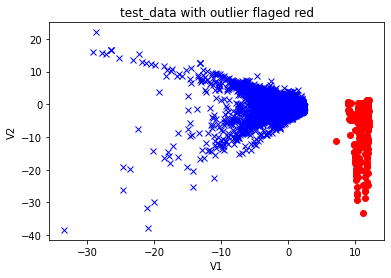

In [74]:
#outliers identified on test data feature column V1 V2
plt.figure()
plt.title("test_data with outlier flaged red")
plt.xlabel("V1")
plt.ylabel("V2")
plt.plot(testFeatures.iloc[:, 1],testFeatures.iloc[:,2],"bx")#plot v1 v2 as blue cross
plt.plot(testFeatures.iloc[predoutliersTest[0],0],testFeatures.iloc[predoutliersTest[0],1],"ro")#re-plot the outliers as red dots
plt.show()

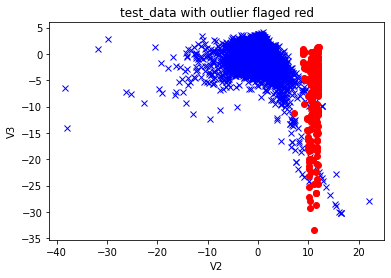

In [75]:
#outliers identified on test data feature column V2 V3
plt.figure()
plt.title("test_data with outlier flaged red")
plt.xlabel("V2")
plt.ylabel("V3")
plt.plot(testFeatures.iloc[:, 2],testFeatures.iloc[:,3],"bx")
plt.plot(testFeatures.iloc[predoutliersTest[0],0],testFeatures.iloc[predoutliersTest[0],1],"ro")
plt.show()

In [76]:
# generate evaluation metrics
print("%s: %r" % ("accuracy_score is: ", accuracy_score(testLabel, y_pred_test)))
print("%s: %r" % ("roc_auc_score is: ", roc_auc_score(testLabel, y_test_pred_raw)))
print("%s: %r" % ("f1_score is: ", f1_score(testLabel, y_pred_test )))#string to int

print ("confusion_matrix is: ")
cm = confusion_matrix(testLabel, y_pred_test)
cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(cmDF)
print('recall =',float(cm[1,1])/(cm[1,0]+cm[1,1]))
print('precision =', float(cm[1,1])/(cm[1,1] + cm[0,1]))#1.0

accuracy_score is: : 0.9954669084315503
roc_auc_score is: : 0.039756532202350724
f1_score is: : 0.7430830039525692
confusion_matrix is: 
        pred_0  pred_1
true_0   28360      72
true_1      58     188
recall = 0.7642276422764228
precision = 0.7230769230769231
